In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams.update({'figure.autolayout': True})
'''
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from preprocessing import *
from utils import *
from models import *
from parameters import *
'''
import seaborn as sns
sns.set()
rcParams['figure.figsize']=(15, 8)
plt.style.use('ggplot')

In [2]:
EVENTS_FILE = "data/football-events/events.csv"
GAME_INFO_FILE = "data/football-events/ginf.csv"

In [3]:
game_info_df = pd.read_csv(GAME_INFO_FILE)
game_info_df.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


In [4]:
# Show leagues available
leagues = game_info_df['league'].unique()
seasons = game_info_df['season'].unique()
print("Leagues:", leagues)
print("Seasons:", seasons)

Leagues: ['D1' 'F1' 'E0' 'SP1' 'I1']
Seasons: [2012 2013 2014 2015 2016 2017]


In [5]:
# Filter games
leagues_mask = game_info_df['league'] == 'E0'
seasons_mask = game_info_df['season'] <= 2015
game_info_df = game_info_df[leagues_mask]
game_info_train_df = game_info_df[seasons_mask]
game_info_test_df = game_info_df[~seasons_mask]
print("Games in training data:", game_info_train_df.shape[0])
print("Games in test data:", game_info_test_df.shape[0])

Games in training data: 1520
Games in test data: 600


/Users/valentin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/valentin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [6]:
home_teams, away_teams = get_home_and_away_teams(game_info_train_df)
print("Nb teams home: %d" % home_teams.size)
print("Nb teams away: %d" % away_teams.size)
assert(np.array_equal(home_teams, away_teams))

Nb teams home: 28
Nb teams away: 28


In [7]:
# Remove games containing a team not known before-hand (should we do that?)
print("Test set was %d games" % game_info_test_df.shape[0])
game_info_test_df = game_info_test_df[(game_info_test_df['ht'].isin(home_teams)) & ((game_info_test_df['at'].isin(away_teams)))]
print("Test set: %d games remaining" % game_info_test_df.shape[0])

Test set was 600 games
Test set: 465 games remaining


In [8]:
X = compute_confrontation_matrix(game_info_train_df, home_teams, away_teams)
print("Confrontation matrix shape:", X.shape)

Confrontation matrix shape: (28, 28)


/Users/valentin/Documents/EPFL/SimulatingSportsGame/SportsGameSimulator/preprocessing.py:90: RuntimeWarning: invalid value encountered in true_divide
  X = np.divide(X, counts)


In [9]:
home_teams = get_sorted_teams(home_teams, X, True)
away_teams = get_sorted_teams(away_teams, X, False)

In [10]:
X = get_sorted_confrontation_matrix(X)

In [ ]:
sns.heatmap(X, xticklabels=away_teams, yticklabels=home_teams, cmap="coolwarm")

In [11]:
X = replace_nan_by_mean(X)

In [ ]:
errors = []
max_k = len(away_teams)
for nb_comp in range(2, max_k+1):
    W, H, model = NMF_grid_search(
        X,
        nb_comp,
        inits=NMF_INITS,
        solvers=NMF_SOLVERS,
        beta_losses=NMF_BETA_LOSSES,
        max_iters=NMF_MAX_ITERS,
        alphas=NMF_ALPHAS,
        l1_ratios=NMF_L1_RATIOS,
        shuffles=NMF_SHUFFLES)
    '''
    print("k:", nb_comp)
    print("alpha:", model.alpha)
    print("l1_ratio:", model.l1_ratio)
    print("shuffle:", model.shuffle)
    print('')
    '''
    errors.append(model.reconstruction_err_)

plt.plot(np.arange(2, max_k+1), errors)

In [17]:
k = 2
W, H, model = NMF_grid_search(
    X,
    k,
    inits=NMF_INITS,
    solvers=NMF_SOLVERS,
    beta_losses=NMF_BETA_LOSSES,
    max_iters=NMF_MAX_ITERS,
    alphas=NMF_ALPHAS,
    l1_ratios=NMF_L1_RATIOS,
    shuffles=NMF_SHUFFLES)

print(model.reconstruction_err_)

4.584648784863504


## t-SNE

In [ ]:
# Latent variables for home_teams
W_embedded = TSNE(n_components=2).fit_transform(W)
x = W_embedded[:,0]
y = W_embedded[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10+20*len(home_teams), 10, -20))
for i, team_name in enumerate(home_teams):
    ax.annotate(team_name, (x[i],y[i]))

In [ ]:
# Latent variables for away_teams
H_embedded = TSNE(n_components=2).fit_transform(H.T)
x = H_embedded[:,0]
y = H_embedded[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10, 10+20*len(home_teams), 20))
for i, team_name in enumerate(away_teams):
    ax.annotate(team_name, (x[i], y[i]))

## PCA

In [ ]:
# Latent variables for home_teams
pca_W = PCA(n_components=2)
new_W = pca_W.fit_transform(W)
#print(pca_W.explained_variance_ratio_)
x = new_W[:,0]
y = new_W[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10+20*len(home_teams), 10, -20))
for i, team_name in enumerate(home_teams):
    ax.annotate(team_name, (x[i],y[i]))

In [ ]:
# Latent variables for away_teams
pca_H = PCA(n_components=2)
new_H = pca_H.fit_transform(H.T)
#print(pca_H.explained_variance_ratio_)
x = new_H[:,0]
y = new_H[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10, 10+20*len(away_teams), 20))
for i, team_name in enumerate(away_teams):
    ax.annotate(team_name, (x[i], y[i]))

## Use latent features to predict output of games

In [34]:
# For training
games_latent_train_df = create_latent_df(game_info_train_df, W, H, home_teams, away_teams)
data_labels = games_latent_train_df.columns[1:]
target_label = games_latent_train_df.columns[0]
data, target = get_data_and_target(games_latent_train_df, data_labels, target_label)
games_latent_train_df.head()

,y,home_team_home_latent_1,home_team_home_latent_2,away_team_away_latent_1,away_team_away_latent_2
0,0.500000,0.292074,0.791273,0.583021,0.443296
1,0.500000,0.389074,0.796305,0.386224,0.331178
2,0.017986,0.521343,0.378474,0.355133,0.762535
3,0.500000,0.382976,0.593451,0.766700,0.361898
4,0.500000,0.732418,0.553037,0.837803,0.169159


In [35]:
# For test
games_latent_test_df = create_latent_df(game_info_test_df, W, H, home_teams, away_teams)
data_test, target_test = get_data_and_target(games_latent_test_df, data_labels, target_label)
games_latent_test_df.head()

,y,home_team_home_latent_1,home_team_home_latent_2,away_team_away_latent_1,away_team_away_latent_2
0,0.500000,0.743956,0.725184,0.872973,0.144214
1,0.880797,0.742848,0.293159,0.837803,0.169159
2,0.119203,0.597590,0.516129,0.335902,0.616830
3,0.731059,0.714847,0.749603,0.499163,0.270156
4,0.500000,0.389074,0.796305,0.657198,0.287195


### How good bookmakers are doing?

Prob. correctly classifying game: 0.38365748737235594


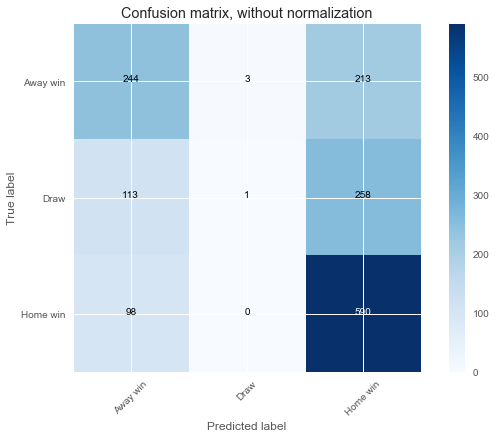

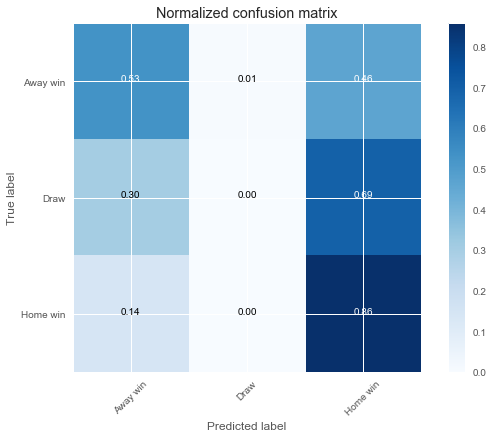

Bookies accuracy: 0.5875


In [54]:
y_true = sigmoid_values_to_classes(target)
y_pred = get_bookies_pred(game_info_train_df)
y_pred_proba = get_bookies_pred(game_info_train_df, classes_proba=True)

print("Prob. correctly classifying game:", log_loss_proba(y_true, y_pred_proba, labels=[-1, 0, 1]))

plot_confusion_matrices(y_true, y_pred)

print("Bookies accuracy:", get_bookies_accuracy(game_info_train_df))

### Regressors

#### Using NN regression

In [ ]:
from sklearn.neural_network import MLPRegressor

parameters = {
    'hidden_layer_sizes': MLP_REG_LAYERS_SIZES,
    'activation': MLP_REG_ACTIVATIONS,
    'solver': ['adam'],
    'alpha': MLP_REG_ALPHAS,
    'learning_rate': MLP_REG_LEARNING_RATES}

mlp = MLPRegressor(max_iter=500)
model = grid_search_CV_report(mlp, data, target, parameters, scoring=reg_score_function())

y_pred = reg_to_classes(model.predict(data_test))
y_true = sigmoid_values_to_classes(target_test)
plot_confusion_matrices(y_true, y_pred)

print("\nTest score:", model.score(data_test, target_test))

For k = 2, best test score: 0.50108, best params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50, 10), 'learning_rate': 'constant', 'solver': 'adam'}
For k = 4, best test score: 0.48172, best params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50, 10), 'learning_rate': 'constant', 'solver': 'adam'}
For k = 6, best test score: 0.47312, best params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50, 10), 'learning_rate': 'constant', 'solver': 'adam'}
For k = 8, best test score: 0.46667, best params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
For k = 10, best test score: 0.48602, best params: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


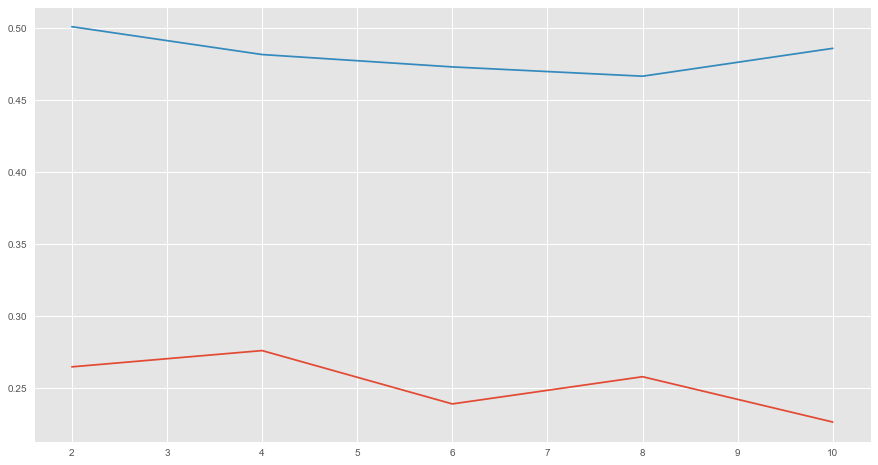

In [15]:
max_k = 10
parameters = {
    'hidden_layer_sizes': MLP_REG_LAYERS_SIZES,
    'activation': MLP_REG_ACTIVATIONS,
    'solver': ['adam'],
    'alpha': MLP_REG_ALPHAS,
    'learning_rate': MLP_REG_LEARNING_RATES}

mlp = MLPRegressor(max_iter=500)

k_and_scores = get_NMF_scores(X, max_k, game_info_train_df, game_info_test_df,
                              home_teams, away_teams, mlp, parameters, classifying=False)

ks = [x[0] for x in k_and_scores]
training_scores = [x[1] for x in k_and_scores]
test_scores = [x[2] for x in k_and_scores]
plt.plot(ks, training_scores)
plt.plot(ks, test_scores)
plt.show()


### Classifiers

In [56]:
games_latent_train_df = continuous_to_win_draw_loss_df(games_latent_train_df, target_label)
games_latent_test_df = continuous_to_win_draw_loss_df(games_latent_test_df, target_label)
if BALANCE:
    games_latent_df = balance_df(games_latent_train_df, target_label)
    
data, target = get_data_and_target(games_latent_train_df, data_labels, target_label)
data_test, target_test = get_data_and_target(games_latent_test_df, data_labels, target_label)

games_latent_train_df.groupby(target_label)[target_label].count() / games_latent_train_df.shape[0]

y
-1    0.302632
 0    0.244737
 1    0.452632
Name: y, dtype: float64

In [25]:
games_latent_test_df.groupby(target_label)[target_label].count() / games_latent_test_df.shape[0]

y
-1    0.290323
 0    0.268817
 1    0.440860
Name: y, dtype: float64

#### Using SVM Classifier

In [ ]:
from sklearn import svm

parameters = {
    'C': SVM_CS,
    'kernel': SVM_KERNELS,
    'shrinking': SVM_SHRINKINGS}

svc = svm.SVC()
model = grid_search_CV_report(svc, data, target, parameters, cv=3)

y_pred = model.predict(data_test)
y_true = target_test
plot_confusion_matrices(y_true, y_pred)

print("\nTest score:", model.score(data_test, target_test))

#### Using NN Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

parameters = [
    {'hidden_layer_sizes': MLP_CLS_LAYERS_SIZES,
    'activation': MLP_CLS_ACTIVATIONS,
    'solver': ['adam'],
    'alpha': MLP_CLS_ALPHAS}]

mlp = MLPClassifier(max_iter=500)
model = grid_search_CV_report(mlp, data, target, parameters, cv=3)

y_pred = model.predict(data_test)
y_true = target_test
plot_confusion_matrices(y_true, y_pred)

print("\nTest score:", model.score(data_test, target_test))

#### Gaussian Naive Bayes

Tuning hyper-parameters...
Done.
Best parameters set (out of 1):

{}
Score: 0.5039473684210526

Grid scores on development set (top 10):

0.504 (+/-0.017) for {}
Prob. correctly classifying game: 0.3530938778457441


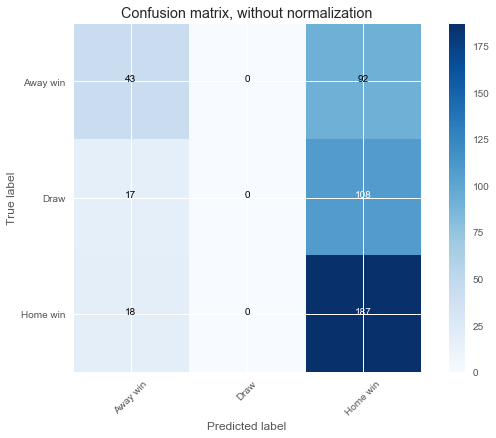

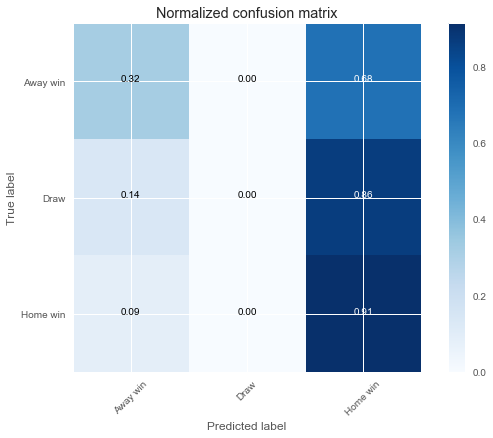


Test score: 0.4946236559139785


In [58]:
from sklearn.naive_bayes import GaussianNB

parameters = {}

gnb = GaussianNB()
model = grid_search_CV_report(gnb, data, target, parameters)

y_pred_proba = model.predict_proba(data_test)
y_pred = model.predict(data_test)
y_true = target_test
print("Prob. correctly classifying game:", log_loss_proba(y_true, y_pred_proba, labels=[-1, 0, 1]))

plot_confusion_matrices(y_true, y_pred)

print("\nTest score:", model.score(data_test, target_test))

#### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters = [
    {'n_estimators': [10, 50, 100, 1000],
    'max_depth': [3, 5, 10]}]

rfc = RandomForestClassifier()
model = grid_search_CV_report(rfc, data, target, parameters, cv=3)

y_pred = model.predict(data_test)
y_true = target_test
plot_confusion_matrices(y_true, y_pred)

print("\nTest score:", model.score(data_test, target_test))

#### Gradient Boosting Classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 10]}

gbc = GradientBoostingClassifier()
model = grid_search_CV_report(gbc, data, target, parameters, cv=3)

y_pred = model.predict(data_test)
y_true = target_test
plot_confusion_matrices(y_true, y_pred)

print("\nTest score:", model.score(data_test, target_test))

## Iterate over everything

In [ ]:
(svm.SVC(), 
 {'C': SVM_CS,
'kernel': SVM_KERNELS,
'shrinking': SVM_SHRINKINGS}),

estimators_and_params = [
    (MLPClassifier(max_iter=500),
    {'hidden_layer_sizes': MLP_CLS_LAYERS_SIZES,
    'activation': MLP_CLS_ACTIVATIONS,
    'solver': ['adam'],
    'alpha': MLP_CLS_ALPHAS}),
    (GaussianNB(), {}),
    (RandomForestClassifier(),
    {'n_estimators': [10, 50, 100, 1000],
    'max_depth': [3, 5, 10]}),
    (GradientBoostingClassifier(),
    {'n_estimators': [10, 50, 100],
    'max_depth': [3, 5, 10]})
]

max_k = len(away_teams)
for estimator, param in estimators_and_params:
    print("Start")
    k_and_scores = get_NMF_scores(
        X,
        max_k,
        game_info_train_df,
        game_info_test_df,
        home_teams,
        away_teams,
        estimator,
        param)
    
    ks = [x[0] for x in k_and_scores]
    training_scores = [x[1] for x in k_and_scores]
    test_scores = [x[2] for x in k_and_scores]
    plt.plot(ks, training_scores)
    plt.plot(ks, test_scores)
    plt.show()

## A look at the events

In [4]:
events_df = pd.read_csv(EVENTS_FILE)
test_ids_df = pd.read_csv('data/football-events/test_ids.csv')
events_df = events_df[events_df['id_odsp'].isin(test_ids_df['test_id'].values)]
print(events_df.shape)
events_df.head()

(301624, 22)


,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
634414,tr68gYbd/,tr68gYbd1,1,3,Foul by Joo-Ho Park (1. FSV Mainz 05).,3,NaN,1,Mainz,Schalke 04,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
634415,tr68gYbd/,tr68gYbd2,2,3,Jefferson Farfan (FC Schalke 04) wins a free k...,8,NaN,2,Schalke 04,Mainz,...,NaN,NaN,NaN,NaN,0,5.0,NaN,0,NaN,0
634416,tr68gYbd/,tr68gYbd3,3,4,Attempt saved. Klaas-Jan Huntelaar (FC Schalke...,1,12.0,2,Schalke 04,Mainz,...,NaN,NaN,4.0,1.0,0,9.0,2.0,3,1.0,0
634417,tr68gYbd/,tr68gYbd4,4,4,"Corner, FC Schalke 04. Conceded by Loris Karius.",2,NaN,2,Schalke 04,Mainz,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
634418,tr68gYbd/,tr68gYbd5,5,4,Attempt blocked. Eric Choupo-Moting (FC Schalk...,1,12.0,2,Schalke 04,Mainz,...,NaN,NaN,2.0,3.0,0,3.0,3.0,2,1.0,0


In [5]:
events_with_goals_df = events_df.copy()
events_with_goals_df.loc[(events_with_goals_df['event_type'] == 1) & (events_with_goals_df['text'].str.startswith('Goal')), 'event_type'] = 0


/usr/local/Cellar/python3/3.6.0_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


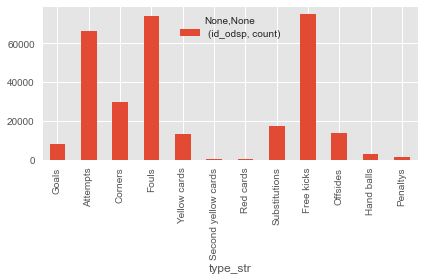

In [6]:
events = ['Goals', 'Attempts', 'Corners', 'Fouls', 'Yellow cards', 'Second yellow cards', 'Red cards', 'Substitutions', 'Free kicks', 'Offsides', 'Hand balls', 'Penaltys']
event_types_df = events_with_goals_df[['id_odsp', 'event_type']].groupby(['event_type']).agg(['count'])
event_types_df['type_str'] = events
event_types_df.plot(kind='bar', x='type_str')

Index(['Count'], dtype='object')


/usr/local/Cellar/python3/3.6.0_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Index(['Count'], dtype='object')
Index(['Count'], dtype='object')
Index(['Count'], dtype='object')
Index(['Count'], dtype='object')
Index(['Count'], dtype='object')
Index(['Count'], dtype='object')
Index(['Count'], dtype='object')
Index(['Count'], dtype='object')
Index(['Count'], dtype='object')
Index(['Count'], dtype='object')
Index(['Count'], dtype='object')


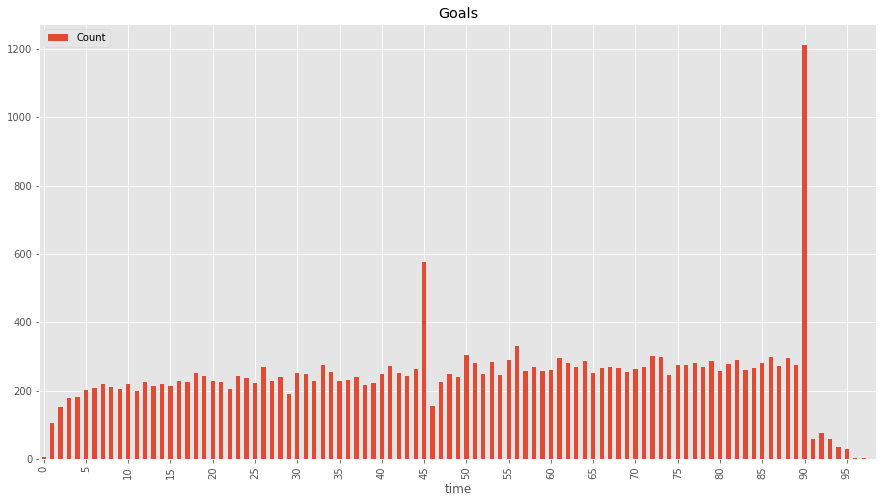

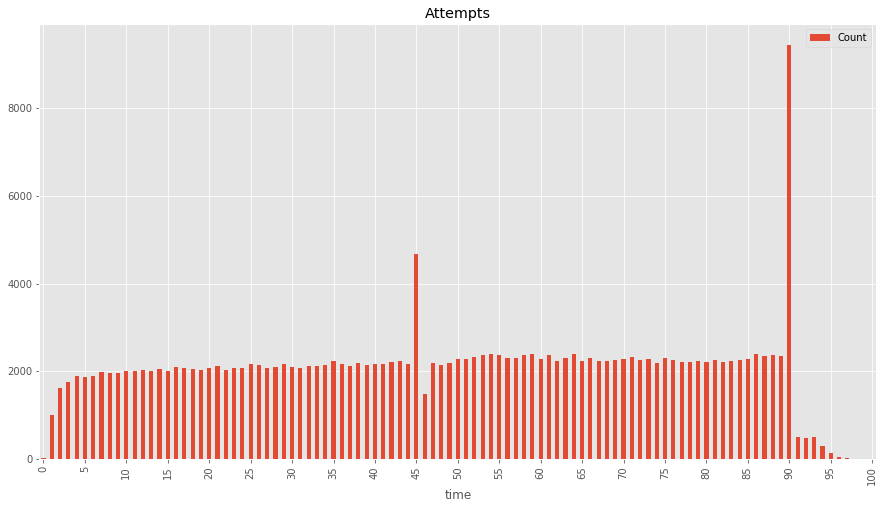

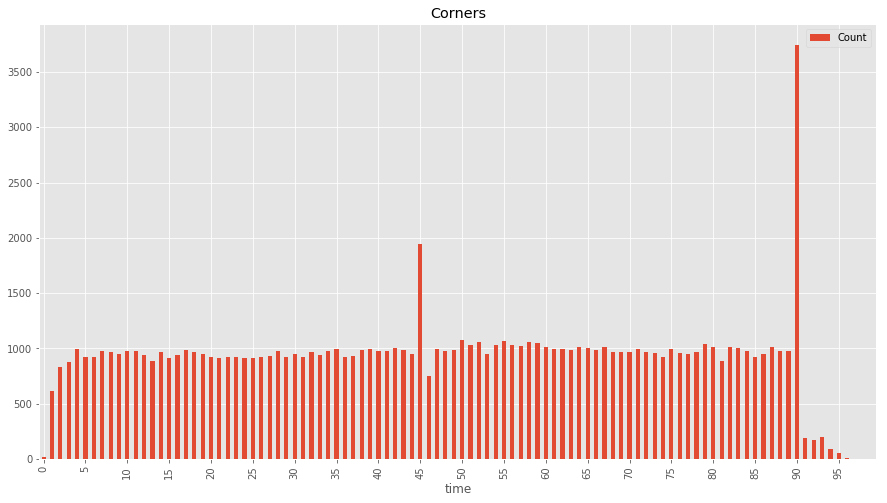

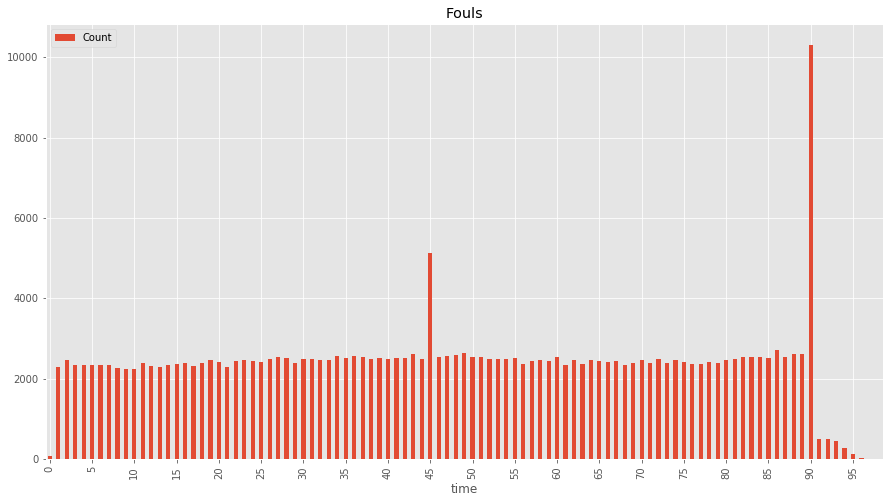

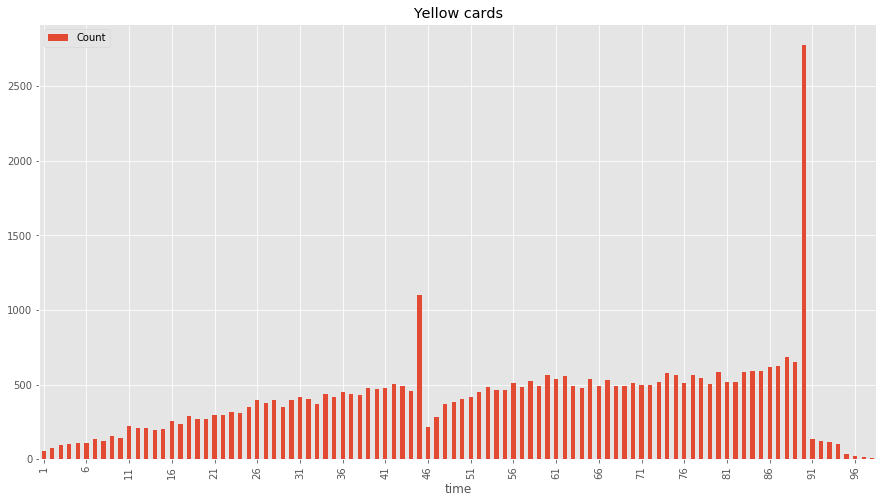

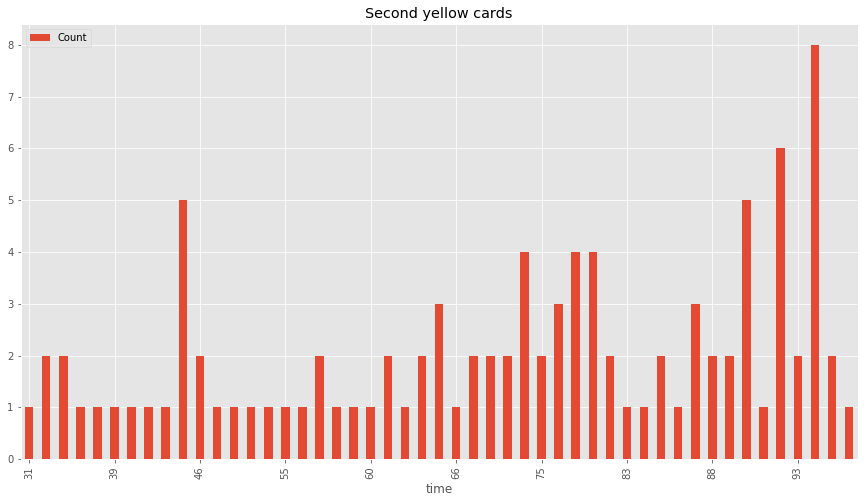

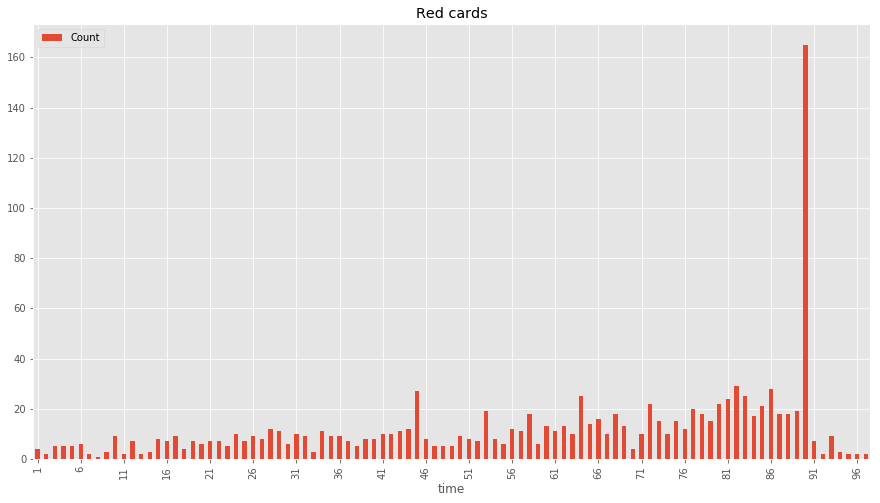

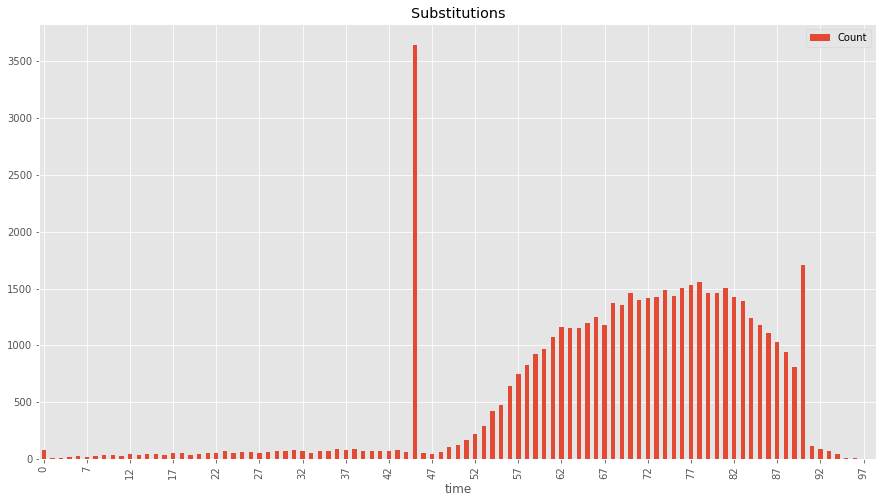

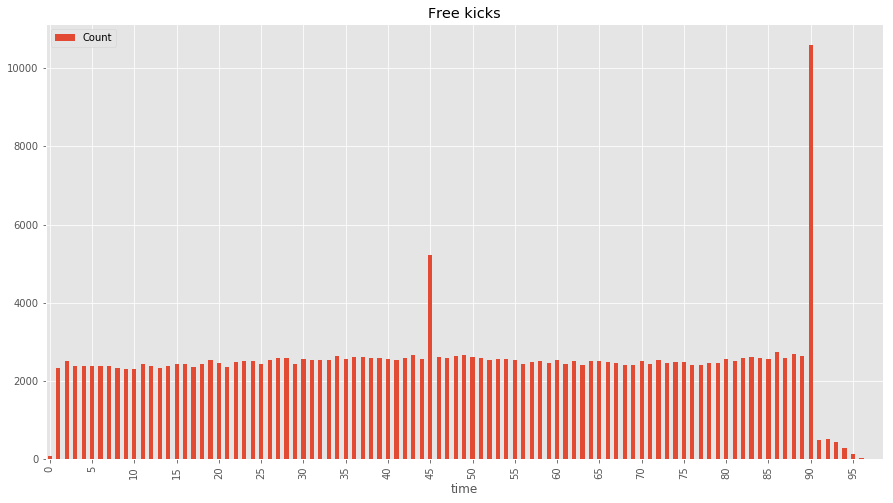

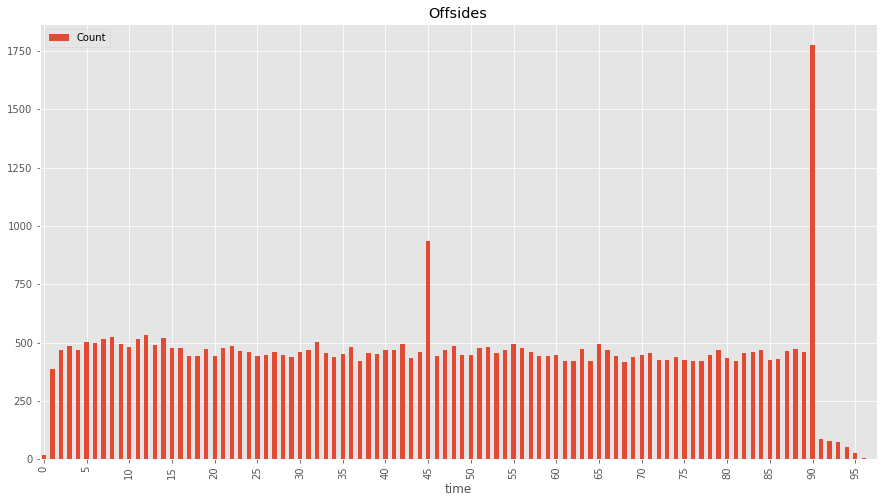

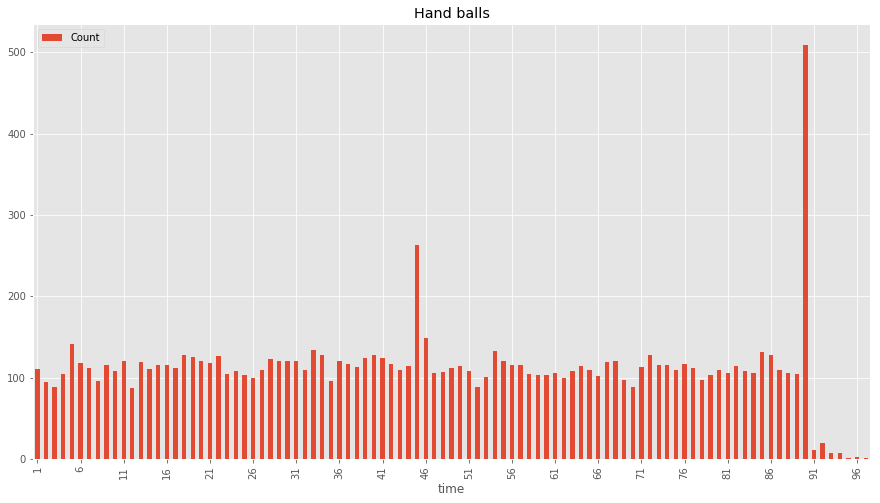

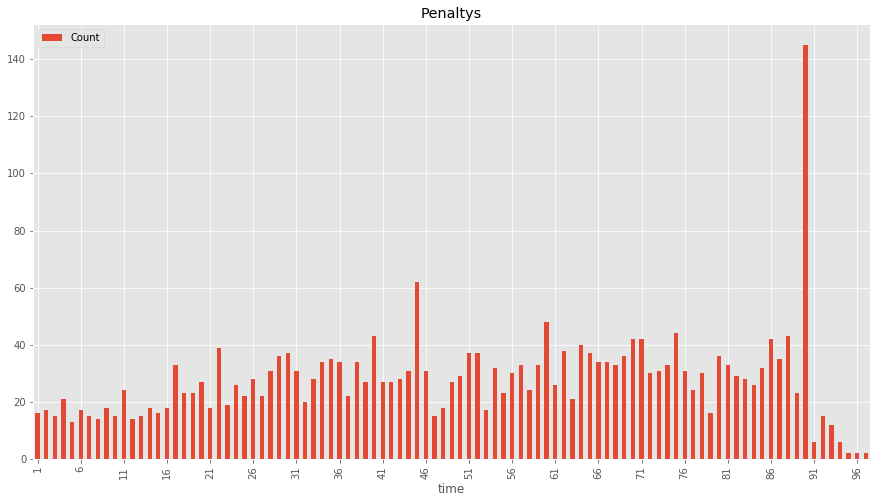

In [42]:
for i in range(len(events)):
    temp_df = events_with_goals_df[events_with_goals_df['event_type'] == i][['id_odsp', 'time']].groupby(['time']).agg(['count'])
    temp_df.columns = ['Count']
    print(temp_df.columns)
    ax = temp_df.plot(title=events[i], kind='bar')
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::5])
    ax.xaxis.set_ticklabels(ticklabels[::5])
    ax.figure.savefig('images/events_time_distr/%d_distr.pdf' % i)
    ax.figure.show()
    #print(temp_df.index.values)
    #plt.axis([0, 105, 0, 10000])
    #plt.xticks(np.arange(0, 105, 5.0), labels=temp_df.index.values)
    #print(temp_df)


In [7]:
events_df = events_df[['id_odsp', 'time', 'event_type', 'side', 'event_team', 'opponent']]
events_df.head(10)

,id_odsp,time,event_type,side,event_team,opponent
634414,tr68gYbd/,3,3,1,Mainz,Schalke 04
634415,tr68gYbd/,3,8,2,Schalke 04,Mainz
634416,tr68gYbd/,4,1,2,Schalke 04,Mainz
634417,tr68gYbd/,4,2,2,Schalke 04,Mainz
634418,tr68gYbd/,4,1,2,Schalke 04,Mainz
634419,tr68gYbd/,4,1,2,Schalke 04,Mainz
634420,tr68gYbd/,6,3,1,Mainz,Schalke 04
634421,tr68gYbd/,6,8,2,Schalke 04,Mainz
634422,tr68gYbd/,8,1,2,Schalke 04,Mainz
634423,tr68gYbd/,12,8,1,Mainz,Schalke 04


In [8]:
transition_table = [[0] * 12 for _ in range(12)]
transition_table_away = [[0] * 12 for _ in range(12)]
ids_to_events = {}
events_count = [0] * 12
prev_event = None
prev_side = None
prev_id_odsp = None
for idx, row in events_with_goals_df.iterrows():
    id_odsp = row['id_odsp']
    side = int(row['side'])
    time = int(row['time'])
    event_type = int(row['event_type'])
    
    if not prev_id_odsp is None and prev_id_odsp != id_odsp:
        prev_side = None
        prev_event = None
        
    if not id_odsp in ids_to_events:
        if side == 1:
            home_team = row['event_team']
            away_team = row['opponent']
        else:
            home_team = row['opponent']
            away_team = row['event_team']
            
        ids_to_events[id_odsp] = ("%s -VS- %s" % (home_team, away_team), [])
        
    ids_to_events[id_odsp][1].append((time, event_type))
    
    if not prev_event is None and not prev_side is None and prev_side == side:
        transition_table[prev_event][event_type] += 1
        
    if not prev_event is None and not prev_side is None and prev_side != side:
        transition_table_away[prev_event][event_type] += 1
        
    events_count[event_type] += 1
        
    prev_event = event_type
    prev_side = side

events_proba = [[0] * 12 for _ in range(12)]
away_events_proba = [[0] * 12 for _ in range(12)]

total_proba = 0
for prev_event, event_list in enumerate(transition_table):
    for new_event, count in enumerate(event_list):
        proba = (count / events_count[prev_event])
        proba_normalized = proba / (events_count[new_event] / len(events_with_goals_df))
        total_proba += proba
        events_proba[prev_event][new_event] = proba_normalized
        #print("From %s to %s: %.4f and %.4f" % (events[prev_event], events[new_event], proba, proba_normalized))
                
for prev_event, event_list in enumerate(transition_table_away):
    for new_event, count in enumerate(event_list):
        proba = (count / events_count[prev_event])
        proba_normalized = proba / (events_count[new_event] / len(events_with_goals_df))
        total_proba += proba
        away_events_proba[prev_event][new_event] = proba_normalized
        #print("From %s to %s: %.4f and %.4f" % (events[prev_event], events[new_event], proba, proba_normalized))


/usr/local/Cellar/python3/3.6.0_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


,Goals,Attempts,Corners,Fouls,Yellow cards,Second yellow cards,Red cards,Substitutions,Free kicks,Offsides,Hand balls,Penaltys
Goals,0.555446,0.468167,0.337206,0.589387,0.345978,0.000000,0.220319,0.833236,0.328638,0.667471,0.940446,0.416691
Attempts,0.934029,0.755540,1.733249,0.474984,0.075583,0.000000,0.156427,0.486655,0.260044,0.756232,0.686754,0.493085
Corners,1.219626,1.685243,0.863322,0.435376,0.082332,0.000000,0.058421,0.468547,0.173206,0.747879,0.607029,0.736614
Fouls,0.157308,0.149592,0.135703,0.127004,1.215070,0.904751,0.877452,0.228468,0.091775,0.193056,0.222099,0.106947
Yellow cards,0.337107,0.334875,0.280713,0.353623,0.303301,1.175064,0.668571,0.904295,0.236562,0.415438,0.585787,0.400416


/usr/local/Cellar/python3/3.6.0_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


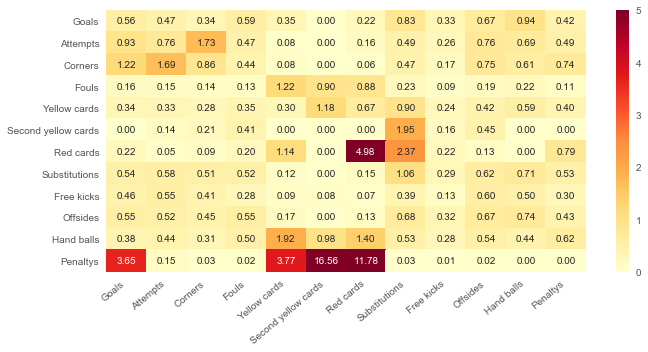

In [9]:
plt.figure(figsize=(10,5))
home_events_df = pd.DataFrame(events_proba, columns=events).set_index([events])
home_events_df.to_pickle('events_simulation/events_transition/same_side_event_influence.pkl')
ax = sns.heatmap(home_events_df, cmap='YlOrRd', annot=True, vmin=0, vmax=5, fmt='.2f')
ax.set_xticklabels(events, rotation=40, ha='right')
ax.figure.show()
ax.figure.savefig('images/events_prev_event_distr/same_side_event_influence.pdf')
home_events_df.head()

/usr/local/Cellar/python3/3.6.0_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


,Goals,Attempts,Corners,Fouls,Yellow cards,Second yellow cards,Red cards,Substitutions,Free kicks,Offsides,Hand balls,Penaltys
Goals,0.496978,0.551192,0.536170,0.479686,0.354849,0.387228,0.220319,1.224164,0.343414,0.724277,0.767206,0.694484
Attempts,0.400133,0.427371,0.367228,0.410873,0.135770,0.000000,0.117320,0.636272,0.262033,0.567342,0.629646,0.587593
Corners,0.322994,0.305768,0.237071,0.281972,0.141141,0.000000,0.058421,0.511788,0.251163,0.365278,0.488904,0.349892
Fouls,0.276324,0.332862,0.241906,0.205481,0.054331,0.000000,0.070196,0.232738,2.524353,0.313415,0.249697,0.228646
Yellow cards,1.522894,1.058512,0.577109,0.461657,0.568915,0.705039,0.601714,0.877180,0.359327,0.815363,0.510686,0.632236


/usr/local/Cellar/python3/3.6.0_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


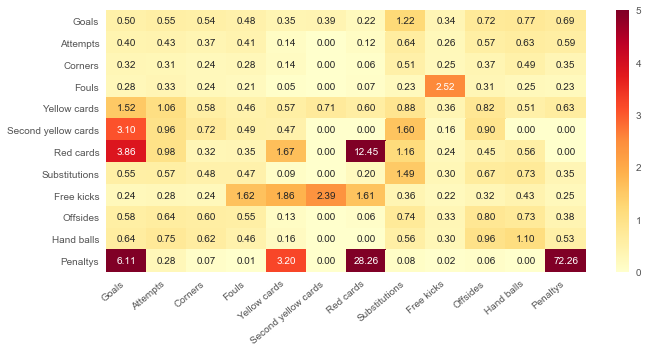

In [10]:
plt.figure(figsize=(10,5))
away_events_df = pd.DataFrame(away_events_proba, columns=events).set_index([events])
away_events_df.to_pickle('events_simulation/events_transition/other_side_event_influence.pkl')
ax = sns.heatmap(away_events_df, cmap='YlOrRd', annot=True, vmin=0, vmax=5, fmt='.2f')
ax.set_xticklabels(events, rotation=40, ha='right')
ax.figure.show()
ax.figure.savefig('images/events_prev_event_distr/other_side_event_influence.pdf')
away_events_df.head()

(2, 1)
2
1
9
1
10
1
13
1
17
1
19
1
26
1
28
1
29
1
38
1
39
1
43
1
56
1
63
1
64
1
70
1
78
1
81
1
85
1
86
1
89
1
4
2
7
2
11
2
27
2
31
2
33
2
45
2
48
2
49
2
50
2
53
2
55
2
57
2
59
2
60
2
62
2
69
2
76
2
79
2
82
2
87
2
14
3
20
3
32
3
36
3
42
3
47
3
54
3
66
3
68
3
73
3
74
3
80
3
84
3
25
4
90
4


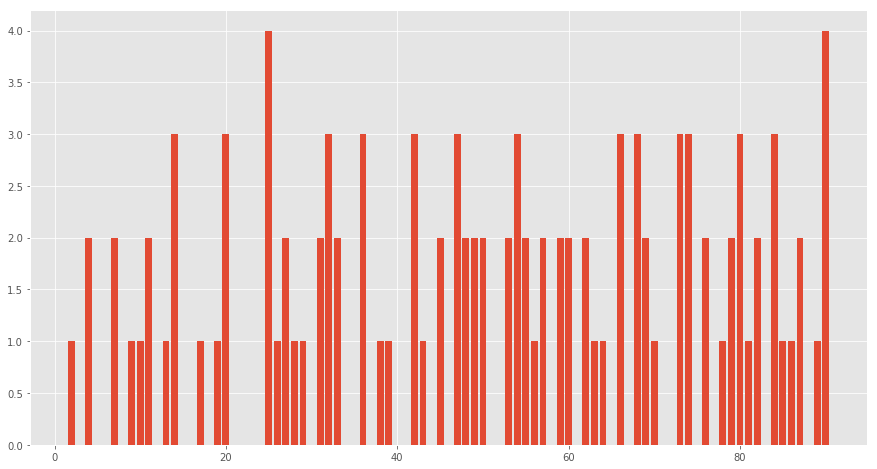

In [45]:
import collections

for id_odsp, event in ids_to_events.items():
    print(event[1][0])
    new_l = list(map(lambda x: x[0], event[1]))
    counter = collections.Counter(new_l)
    sorted_minutes = []
    sorted_count = []
    for key, value in sorted(counter.items(), key=lambda x: (x[1],x[0])):
        print(key)
        print(value)
        sorted_minutes.append(key)
        sorted_count.append(value)
    
    plt.bar(sorted_minutes, sorted_count)
    break

In [22]:
events_df = events_df[['id_odsp', 'time', 'side', 'event_type', 'event_team', 'opponent']]
#ids_to_df = dict(tuple(events_df[['id_odsp', 'time', 'side', 'event_type', 'event_team', 'opponent']].groupby('id_odsp')))
ids_to_df = {key: events_df.loc[value] for key, value in events_df.groupby("id_odsp").groups.items()}    

games_to_events = {}
for idd, df in ids_to_df.items():
    side = int(df['side'].iloc[0])
    event_team = df['event_team'].iloc[0]
    opponent = df['opponent'].iloc[0]
    if side == 1:
        home_team = event_team
        away_team = opponent
    elif side == 2:
        home_team = opponent
        away_team = event_team
    else:
        raise Exception()
        
    games_to_events[(idd, home_team, away_team)] = df[['time', 'side', 'event_type']]
    
games_to_events[('UFot0hit/', 'Borussia Dortmund', 'Hamburg SV')]

,time,side,event_type
0,2,2,1
1,4,1,2
2,4,1,2
3,7,1,3
4,7,2,8
5,9,2,10
6,10,2,2
7,11,1,8
8,11,2,3
9,13,2,3
